# Implementation of Decision Tree Algorithms From Scratch

### Task : Create two classifiers: ID3 and CART.

**Tools & libraries**: Python, Jupyter, pandas, scikit-learn, numpy, timeit, graphviz

**DATASETS** :
- PlayOut (With nominal features)
- PlayOut_num (With both nominal and numerical features)
- [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris)

In [ ]:
%pip install -qU pandas scikit-learn numpy timeit graphviz

## 1. INTRODUCTION

A decision tree is a very simple machine learning model. It was widely used in the 1960s-1980s for building expert systems. It is widely known and used in many companies to facilitate decision making and risk analysis.

Given dataset with many features, the decision starts by selecting one of these features (the most appropriate and relevant one, following some defined criteria) ; if this is not sufficient, another feature is selected, and so on.

At their creation, the rules were introduced manually, for this reason this model lost its popularity after the 1980s, but the appearance of mathematical methods for building decision trees brings this model back into the battle of machine learning (ML) algorithms. There are several ML algorithms for building decision trees. So far in this lab, we will learn about :

- **ID3 (Iterative Dichotomiser 3)** [[JR Quinlan, 1986](https://link.springer.com/content/pdf/10.1007/BF00116251.pdf)]: It was developed in 1986 by Ross Quinlan. It can be applied only on nominal features. It is used for ranking.
- **C4.5** [[JR Quinlan, 1993](https://books.google.fr/books?hl=fr&lr=&id=b3ujBQAAQBAJ&oi=fnd&pg=PP1&dq=C4.+5:+Programs+for+machine+learning&ots=sR7pRTJuC2&sig=hmtbed3-eUljdUvf6eoM2vfrbHQ&redir_esc=y#v=onepage&q=C4.%205%3A%20Programs%20for%20machine%20learning&f=false)] : an extension of ID3 by Ross Quinlan. It can be applied to all types of features. It is used for classification.
- **C5.0** [[JR Quinlan, 2004](https://www.rulequest.com/see5-info.html)] : a commercial extension of C4.5, again by Ross Quinlan.
- **CART (Classification and Regression Trees)** [Breiman et al. , 1984](Refrence) : like C4.5 but uses other metrics. Also, the algorithm supports regression.

### 1.1 The general algorithm for creating a decision tree:

1. Determine the best feature in the training data set.
2. Divide the training data into subsets containing the possible values of the best feature.
3. Recursively generate new decision trees using the subsets of data created.
4. When the data can no longer be classified, stop.

### 1.2 Benefits
- They are simple to understand and interpret.
- The decision trees can be visualised. Also, the results obtained can be easily explained.
- They can work on data with lightwheith preprocessing of data e.g., they do not need data normalisation.
- They accept both numerical and nominal data. Other learning algorithms are specialised in one type of data.
- They perform well even if their assumptions are somewhat violated by the actual model from which the data was generated.

### 1.3 Limitations
- They can be as complex, they do not generalise well (they generally tend to over-fit the data); this can be fixed by setting the minimum number of samples in the leaves and the maximum depth of the tree.
- They can be unstable because of variations in the data.
- There are some concepts that are a bit difficult to learn from decision trees. They are not easy to express, for example: XOR operation.
- They can be biased to the dominant class. So you have to balance the data before training the system.
- It is not guaranteed that the optimal decision tree will be found.

## 2. Implementation

In this lab, we will implement ID3 for the nominal features and CART (ranking) for the numerical features only.

In [1]:
import matplotlib
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Check our libraries versions
print("numpy version :",np.__version__)
print("pandas version :",pd.__version__)
print("matplotlib version :",matplotlib.__version__)

numpy version : 1.26.4
pandas version : 2.2.2
matplotlib version : 3.10.0


In [2]:
# Support for type hints
from typing          import Tuple, List, Type, Union
from collections.abc import Callable

In [4]:
!pwd

/content


- In this section we will improve our understanding of the machine learning algorithms seen in class by implementing them from scratch.
- To do this, we will use the numpy library which is useful for computations, especially matrix operations.

### 2.1 ID3 (Iterative Dichotomiser 3) [[JR Quinlan, 1986](https://link.springer.com/content/pdf/10.1007/BF00116251.pdf)]

- This algorithm only works on nominal features.
- So, if we have continuous features, we have to apply the discretization.
- Also, it is used for classification task only (not for regression task).

#### 2.1.1 Reading and preparation of data
- We will use a small dataset named "PlayOut" that contains only nominal features (variables).

In [5]:
# Read dataset "PlayOut.csv" using pandas.read_csv
df_playOut = pd.read_csv("data/PlayOut.csv")
# Print the DataFrame df_playOut
df_playOut

,weather,temperature,humidity,wind,playOut
0,sunny,hot,high,no,no
1,sunny,hot,high,yes,no
2,cloudy,hot,high,no,yes
3,rainy,cool,high,no,yes
4,rainy,mild,dry,no,yes
5,rainy,mild,dry,yes,no
6,cloudy,mild,dry,yes,yes
7,sunny,cool,high,no,no
8,sunny,mild,dry,no,yes
9,rainy,cool,dry,no,yes


Next, we need to separate data into : (1) inputs noted X, and (2) outputs(labels, classes) noted Y.

In [6]:
# Get the first columns that represents the features
X_playOut = df_playOut.iloc[:, :-1].values

# Get the last column of labels (classes)
Y_playOut = df_playOut.iloc[:,-1].values

# Print X
print("X_playOut : \n",X_playOut[:, :])

# Print Y
print("\nY_playOut : \n",Y_playOut)

X_playOut : 
 [['sunny' 'hot' 'high' 'no']
 ['sunny' 'hot' 'high' 'yes']
 ['cloudy' 'hot' 'high' 'no']
 ['rainy' 'cool' 'high' 'no']
 ['rainy' 'mild' 'dry' 'no']
 ['rainy' 'mild' 'dry' 'yes']
 ['cloudy' 'mild' 'dry' 'yes']
 ['sunny' 'cool' 'high' 'no']
 ['sunny' 'mild' 'dry' 'no']
 ['rainy' 'cool' 'dry' 'no']
 ['sunny' 'cool' 'dry' 'yes']
 ['cloudy' 'cool' 'high' 'yes']
 ['cloudy' 'hot' 'dry' 'no']
 ['rainy' 'cool' 'high' 'yes']]

Y_playOut : 
 ['no' 'no' 'yes' 'yes' 'yes' 'no' 'yes' 'no' 'yes' 'yes' 'yes' 'yes' 'yes'
 'no']


#### 2.1.2 Probability function

Let :

$S$ : Be a set of values (we represent that with a strings vector in python).

$v$ : Be a value (in our case it represents a string value)

**The probability of occurrence of a value $v$ in $S$ is** : the number of occurrences of $v$ in $S$ divided by the total number of elements of the set $S$, as written in the following formula :

$$p(S = v) = \frac{|\{x \in S / x = v\}|}{|S|}$$

For example, let's take the column "PlayOut".
The number of "yes" is 9 and the total number of rows is 14, therefore :
$$p(PlayOut=yes) = \frac{9}{14} = 0.6428571428571429$$

In [7]:
# TODO
# calculate the probability of occurrence of a value val in a set S
# Note : if division always returns 0, try applying float(x) to the numerator or denominator

def P(S: np.ndarray, val: str) -> float:
    '''
    Input :
        S :  is a string vector (array)
        v : String
    Output :
        results :float, the probability of occurrence.
    '''
    ### BEGIN : Write your code here

    results = np.sum(S == val) / len(S)

    ### END
    return results


if we do a hand calculation of the following probabilities with a precision of
5 digits after the decimal point (no rounding), here's what we get :
- $P(PlayOut = yes) = 9/14 = 0.64285$
- $P(weather = sunny) = 5/14 = 0.35714$
- $P(weather = cloudy) = 4/14 = 0.28571$
- $P(weather = rainy) = 5/14 = 0.35714$

In the next cell, we are going to check if our function returns correct answers for this probabilities

In [8]:
#=====================================================================
# UNIT TESTING (Run the cell and compare your results)
#=====================================================================
# Results :
# P(playOut = yes)    =  0.6428571428571429
# P(weather = sunny)  =  0.35714285714285715
# P(weather = cloudy) =  0.2857142857142857
# P(weather = rainy)  =  0.35714285714285715
#---------------------------------------------------------------------
print("P(playOut = yes)    = ",P(Y_playOut, "yes"))
print("P(weather = sunny)  = ",P(X_playOut[:,0], "sunny"))
print("P(weather = cloudy) = ",P(X_playOut[:, 0], "cloudy"))
print("P(weather = rainy)  = ",P(X_playOut[:,0], "rainy"))

P(playOut = yes)    =  0.6428571428571429
P(weather = sunny)  =  0.35714285714285715
P(weather = cloudy) =  0.2857142857142857
P(weather = rainy)  =  0.35714285714285715


#### 2.1.3 Uncertainty of a set

- **The concept of information entropy** was introduced by Claude Shannon in his 1948 paper "A Mathematical Theory of Communication"[(Shannon, Claude E., 1948)](https://pure.mpg.de/rest/items/item_2383164/component/file_2383163/content), and is also referred to as Shannon entropy.

- **Shannon entropy** is the amount of information contained in a source of information; the more different information the source carries, the greater the entropy (or uncertainty about what the source carries).

- Thus, a set with an entropy of 0 contains the same values.

So, Let :
- $S$ be a set of values
- $V$ a set of unique values of $S$

The entropy of $S$ is calculated as follows:
$$H(S) = - \sum\limits_{v \in V} p(v/S) \log_2 p(v/S)$$

For example, the column "PlayOut" contains two values "yes" and "no".  Its entopy is :
$$H(PlayOut) = - \frac{9}{14} * \log_2(\frac{9}{14}) - \frac{5}{14} * \log_2(\frac{5}{14}) = 0.9402859586706309$$

In [9]:
# TODO complete the entropy function
# Hint : The numpy function ''numpy.log2'' computes Base-2 logarithm (log2) of a value, vector or matrix
# See also : https://numpy.org/doc/stable/reference/generated/numpy.log2.html

def H(S: np.ndarray) -> float:
    '''
    Input :
        S : ndarray, set of values
    Output :
        entropy : float, the information entropy score of the set S
    '''
    vals = np.unique(S) # Get the set of unique values of the array S
    entropy  = 0        # Set

    ### BEGIN : Write your code here
    # Hint : Apply the formula using a loop
    entropy = -sum(P(S, val) * np.log2(P(S, val)) for val in vals)

    ### END

    return entropy

**Hand calculation :**


$H(weather) = -P(temps = sunny)*log2(P(weather = sunny)) - P(weather = cloudy)*log2(P(weather=cloudy)) - P(weather=rainy)*log2(P(weather=rainy))$

$H(weather) = - 5/14 * log2(5/14) - 4/14 * log2(4/14) - 5/14 * log2(5/14) = 1.5774062828523454 $

In [10]:
#=====================================================================
# UNIT TEST (Run the cell and compare your results)
#=====================================================================
# Results :
# H(playOut) = 0.9402859586706311
# H(weather) = 1.5774062828523454
#---------------------------------------------------------------------
print("H(playOut) =", H(Y_playOut))
print("H(weather) =", H(X_playOut[:,0]))

H(playOut) = 0.9402859586706311
H(weather) = 1.5774062828523454


#### 2.1.4 Splitting of a set

Here we try to split the list of predictions (classes) according to the values of an attribute (characteristic, column) into sub-lists, Let :
- $S$ : be the list of values to be divided (Represented as a vector, since we have to use the order of the elements)
- $A$ : the set of values of an attribute (characteristic, column). It is a vector aligned with S; i.e., each element of A has a respective element of S.
- $val$ : be the value on which we base our split.

This can be formulated as follows:

$$S_{A, val} = \{v_i \in S  / i \in \{j / a_j \in A \text{ et } a_j = val\}\}$$

Or simply :

$$S_{A,val} = \{s_i \in S / a_i \in A \wedge a_i = val\}\}$$

For example, let's say :
- $S$ is the set of "**PlayOut**" classes e.g., [yes, no, yes , yes , ...]
- $A$ is the set of characteristic values "**weather**" e.g, [sunny, cloudy, ...]
- $val$ is the value "**sunny**"

Therefore, the subset of "**PlayOut**" where (**weather = "sunny"**) contains 3 "no"s and 2 "yes"s Classes.

In [11]:
# TODO complete the function code
# it must return a subset of S
# where the respective values in A are equal to val

def split_ID3(S: np.ndarray, A: np.ndarray, val: str) -> np.ndarray:
    '''
    Input :
        S : numpu.ndarray, the list of values to be divided.
        A : numpu.ndarray, the list of the characteristic values.
        val : string value, on which we base our split.
    Output :
        subset : numpy.ndarray, a subset of S where the respective values in A are equal to val
    '''
    ### BEGIN : Write your code here
    subset = S[A == val]

    ### END
    return subset

In [12]:
#=====================================================================
# UNIT TEST (Run the cell and compare your results)
#=====================================================================
# Results :
# array(['no', 'no', 'no', 'yes', 'yes'], dtype=object)
#---------------------------------------------------------------------
split_ID3(Y_playOut, X_playOut[:,0], "sunny")

array(['no', 'no', 'no', 'yes', 'yes'], dtype=object)

- Now we split the traget column "PlayOut" (Y_playOut) into three subsets according to the values of the "weather" column.
- For each subset, we calculate the entropy.

In [13]:
Y_sunny = split_ID3(Y_playOut, X_playOut[:,0], "sunny")
# PalyOut: 2 yes, 3 no
# H(S_sunny) = - 2/5 * log2(2/5) - 3/5 * log2(3/5) = 0.9709505944546686

Y_cloudy = split_ID3(Y_playOut, X_playOut[:,0], "cloudy") # jouer: 4 oui, 0 non
# P(S_cloudy) = - 4/4 * log2(4/4) - 0/4 * log2(0/4) = 0.0

Y_rainy = split_ID3(Y_playOut, X_playOut[:,0], "rainy") # jouer: 3 oui, 2 non
# P(S_rainy) = - 3/5 * log2(3/5) - 2/5 * log2(2/5) = 0.971

#---------------------------------------------------------------------
# Results :
# H(Y_sunny) = 0.9709505944546686
# H(Y_cloudy)= 0.0
# H(Y_rainy) = 0.9709505944546686
#---------------------------------------------------------------------
print("H(Y_sunny) =", H(Y_sunny))
print("H(Y_cloudy)=", H(Y_cloudy))
print("H(Y_rainy) =", H(Y_rainy))

H(Y_sunny) = 0.9709505944546686
H(Y_cloudy)= -0.0
H(Y_rainy) = 0.9709505944546686


**Note**: the entropy of the set (weather = cloudy) is 0

**Question (Q1)** :
- What does this mean ?
- Do we need to divide this set using another characteristic ?

**Your Answer (A1) :**

- $H = 0$ means no uncertainty. All the values in this subset are the same (in this case, all "yes"). The subset is "pure". So no need for further division

#### 2.1.5 Information Gain

The Information Gain (IG) is the difference between the entropy before and after the division of a set $S$ based on the attribute $A$.

In other words, how much uncertainty in $S$ has been reduced after splitting it using the attribute $A$.

Given :
- $S$: a set (in our case, the set of classes)
- $A$: set of values of an attribute (characteristic, column)
- $V$ : the set of the different values of the attribute $A$
- $P(v/A)$ : the likelihood of occurrence of the value $v$ in $A$
- $S_{A, v}$ : subset of $S$ where the values of $A$ equal $v$  (using the previous function (split_ID3)

The information gain is calculated as follows:

$$IG(S, A) = H(S) - \sum_{v \in V} p(v/A) H(S_{A, v})$$

In [14]:
# TODO Complete the information gain function code
# It must return the information gain and the entropy
# Entropy is returned so that it is not recalculated later

def IG(S: np.ndarray, A: np.ndarray) -> Tuple[float, float]:
    '''
    Inputs :
        S: np.ndarray, array of the target variable (classes)
        A: np.ndarray, array of values of an attribute (characteristic, column) to calculate the IG on.
    Outputs :
        ig_A : the information gain score we obtain if we split S based on A attributes
        ig_global : The global information gain entropy
    '''
    vals = np.unique(A) # Get unique value of the array "A"
    ig_global = H(S)    # Calculate the entropy of the array S before the splits
    ig_A = ig_global    # Set ig_A to the maximum

    ### BEGIN : Write your code here
    # Hint : Apply the formula using a loop

    for val in vals:
        S_A_val = split_ID3(S, A, val)
        p_val = P(A, val)
        ig_A -= p_val * H(S_A_val)
    ### END

    return ig_A, ig_global

**Hand Calculation :**

- $ IG(PlayOut, Weather) = H(Y_playOut) - P(Weather = sunny /A) * H(S_sunny)  
                                        - P(temps = nuageux   /A) * H(S_nuageux)
                                        - P(temps = pluvieux  /A) * H(S_pluvieux) $
                                        

- $ IG(PlayOut, Weather) = 0.9402859586706311 - P(temps = ensoleilé)* (0.9709505944546686)
                                              - P(temps = nuageux)*(0.0)
                                              - P(temps = pluvieux) *(0.9709505944546686) $


- $ IG(PlayOut, Weather) = 0.2467498197744391 $

In [15]:
#=====================================================================
# UNIT TEST (Run the cell and compare your results)
#=====================================================================
# Results :
# IG(Y_playOut, Weather) :  (0.24674981977443933, 0.9402859586706311)
# IG(Y_playOut, temperature) :  (0.02922256565895487, 0.9402859586706311)
# IG(Y_playOut, humidity) :  (0.15183550136234164, 0.9402859586706311)
# IG(Y_playOut, wind) :  (0.048127030408269544, 0.9402859586706311)
#---------------------------------------------------------------------

print("IG(PlayOut, weather) : ",IG(Y_playOut, X_playOut[:, 0]))
print("IG(PlayOut, temperature) : ",IG(Y_playOut, X_playOut[:, 1]))
print("IG(PlayOut, humidity) : ",IG(Y_playOut, X_playOut[:, 2]))
print("IG(PlayOut, wind) : ",IG(Y_playOut, X_playOut[:, 3]))

IG(PlayOut, weather) :  (0.24674981977443933, 0.9402859586706311)
IG(PlayOut, temperature) :  (0.02922256565895487, 0.9402859586706311)
IG(PlayOut, humidity) :  (0.15183550136234164, 0.9402859586706311)
IG(PlayOut, wind) :  (0.048127030408269544, 0.9402859586706311)


**Question (Q2) :**
- What do you think is the ideal feature we should use to divide the first node of our decision tree?
- Why ? (Please provide an explanation)

**Your Answer (A2) :**
[ Write your answer here ]

- Ideal Feature: Weather because it is the highest Information Gain (0.247) which maximizes reduction in uncertainty.


#### 2.1.6 Selection of the ID3 split feature
- The goal here is to code a function that will help us to find the relevant Splitting feature for each given node level.
- To do that, we should look for the feature that maximises IG :
$$ f\_index = \arg\max_i IG(Y, X_i)$$
- The function must return the index of the relevant feature $f\_index$, the IG score of the split using f_index and the entropy

In [16]:
# TODO complete the following function code
# splitting_feature_ID3(X, Y) : seeks the most relevant feature to split Y.
# it must also return the Information Gain (IG) and H(entropy) of this relevant feature.

def splitting_feature_ID3(X: np.ndarray, Y: np.ndarray) -> Tuple[int, float, float]:
    '''
    This function seeks the most relevant feature to split Y.
    Returns the IG and H of selected feature.
    mathematical formula : Max(IG(Y,X[i])) => return the index i (argmax)
    '''
    # create an empty list to get calculate all the Information gain (IG) scores for every feature in X
    IG_vector = []
    # loop over the columns of X and calculate the IG score
    for i in range(X.shape[1]):
        # we append respectively the scores to the IG_vector list of IG scores
        IG_vector.append(IG(Y, X[:, i]))

    ### BEGIN : Write your code here

    # Get the index of the relevant feature
    featureId = np.argmax([ig for ig, _ in IG_vector])

    # Calculate the information gain using this selected feature
    ig        = IG_vector[featureId][0]

    # Calculate the global entropy
    h         = IG_vector[featureId][1]

    # Calculate the information gain using this selected feature
    ig, h = IG_vector[featureId]
    ### END

    return featureId, ig, h

In [17]:
#=====================================================================
# UNIT TEST (Run the cell and compare your results)
#=====================================================================
# Result :
# (0, 0.24674981977443933, 0.9402859586706311)
#---------------------------------------------------------------------
splitting_feature_ID3(X_playOut, Y_playOut)

(0, 0.24674981977443933, 0.9402859586706311)

#### 2.1.7 Creation of the decision tree
*Note : Nothing to code or analyse here.*
- We create a structure for the tree (Node class)
- We implement a recursive function to create a tree from a set

In [18]:
class Node(object):
    '''
    # Node Class : A class to hold the Node information and the list of its children.
    '''
    nbr = 0 # RootID

    def __init__(self, featureId, ig, h, depth):
        self.featureId = featureId    # The featureId of the feature we used for spliting to get this node
        self.ig        = ig           # The Information Gain of the spletting node
        self.h         = h            # the entropy H
        self.depth     = depth        # the depth of the node
        self.children  = {}           # Node children, we store them in a dictionary of type Node
        self.cls       = ""           # the class if this node is final (if there are no children)
        self.indent    = "    "       # indentation when generating the pseaudo code

    def __str__(self):
        '''
        This function (parser) is to transform the node to a string.
        Here we have redefined this function to write the tree as a pseaudo algorithm.
        '''
        indent = self.indent * self.depth               # indentation: aesthetics
        if (len(self.children)==0):                     # IF there are no children, the node is terminal (leaf)
            return indent + 'Y IS "' + self.cls + '"\n' # => we print the class
        res = ""                                        # ELSE, we loop over the children nodes and print IFs ... ELSE

        for childNode in self.children:
            res += indent + 'IF X[' + str(self.featureId) + '] IS "' + str(childNode) + '" THEN\n' + str(self.children[childNode])

        return res

    def predict(self, x: List[str]) -> str:
        '''
        Prediction Function : Given and instnace X it return the predicted target class Y'
        '''
        # IF the node is final, it returns its class
        if (len(self.children)==0):
            return self.cls
        # IF the value of the respective column at this node does not belong to the set of expected values, we return np.nan
        if x[self.featureId] not in self.children:
            return np.nan
        # Else, we do a recursive call and run the instance over the decision tree
        return self.children[x[self.featureId]].predict(x)

    def graphviz(self):
        '''
        This functiongenerate the Pseudocode for graphviz
        '''
        nid = 'N' + str(Node.nbr)
        Node.nbr += 1
        # If the node is a final one,
        if (len(self.children)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        # Else if there are children nodes, we loop over them and print IF ... THEN .. structure
        res = nid + '[label="X[' + str(self.featureId) + ']\\n'
        res += 'H = ' + str(self.h) + '\\n'
        res += 'IG = ' + str(self.ig) + '"];\n'
        for value in self.children:
            vid, code = self.children[value].graphviz()
            res += code
            res += nid + ' -> ' + vid + ' [label="' + value + '"];\n'
        return nid, res

In [19]:
def train_ID3(X, Y, depth=0, pruning=False):
    '''
    Training function : Learn and create the decision tree from a set of X (features) and Y(Target/Labels)
    '''
    featureId, ig, h = splitting_feature_ID3(X, Y)     # Find the best feature of X to split Y
    node = Node(featureId, ig, h, depth)           # Create a node

    if h == 0.0:                                   # If the entropy is 0 then the node is a leaf
        node.cls = Y[0]                            # the class of the node
        return node                                # return the node

    if depth > 3 and pruning:                      # There is no pruning in ID3, but it must be enabled
        node.cls = max(set(Y))                     # To avoid the problem of max recursivity
        return node                                # return the node

                                                   # Else, if the node is not a leaf, we create these children
    depth += 1                                     # the depth of its children
                                                   # the children are created from the unique values of the selected relevant feature
    for val in np.unique(X[:, featureId]):
        msk = X[:, featureId] == val               # These three lines are to retrieve the subsets X_val, Y_val
        X_val = X[msk]                             # corresponding to a value of the selected relevant feature
        Y_val = Y[msk]                             # We do the same operation on the set (Y_val) in a recursive way
        children = train_ID3(X_val, Y_val, depth, pruning)
        node.children[val] = children
                                                  # We assign the created node indexed by the value of the selected relevant feature
                                                  # to the children of the current node
    return node

In [20]:
playOut_Tree = train_ID3(X_playOut, Y_playOut)

print("The Decision Tree ID3 Pseudocode : \n")
print(playOut_Tree)

# Test our model on a sample (new instance) : ["cloudy", "no_temperature", "no_humidity", "no"]
x_test = ["cloudy", "no_temperature", "no_humidity", "no"]
pred = playOut_Tree.predict(x_test)
print("X = ",x_test," | Prediction : Y'=",pred)

The Decision Tree ID3 Pseudocode : 

IF X[0] IS "cloudy" THEN
    Y IS "yes"
IF X[0] IS "rainy" THEN
    IF X[3] IS "no" THEN
        Y IS "yes"
    IF X[3] IS "yes" THEN
        Y IS "no"
IF X[0] IS "sunny" THEN
    IF X[2] IS "dry" THEN
        Y IS "yes"
    IF X[2] IS "high" THEN
        Y IS "no"

X =  ['cloudy', 'no_temperature', 'no_humidity', 'no']  | Prediction : Y'= yes


#### 2.1.8 Bundling all functions together

- *PS : Nothing to code here*
- There is a question to answer.

In [21]:
class ID3(object):

    def train(self, X, Y, X_names=[], Y_name="", pruning=False):
        self.tree = train_ID3(X, Y, pruning=pruning)
        pseudoCode  = str(self.tree)
        if len(Y_name) > 0:
            pseudoCode = pseudoCode.replace("Y", Y_name)
        for i in range(len(X_names)):
            pseudoCode = pseudoCode.replace("X[" + str(i) + "]", X_names[i])
        self.pseudoCode = pseudoCode
        self.X_names = X_names

    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            predictions.append(self.tree.predict(X[i, :]))
        return predictions

    def graphviz(self):
        nid, pseudoCode = self.tree.graphviz()
        res = "digraph Tree {\n"
        res += "node [shape=box] ;"
        for i in range(len(self.X_names)):
            pseudoCode = pseudoCode.replace("X[" + str(i) + "]", self.X_names[i])
        res += pseudoCode
        res += "}"
        return res

In [22]:
# instantiate and train the classifier
id3_classifier  = ID3()

# Training
id3_classifier.train(X_playOut, Y_playOut, X_names=["weather", "temperature", "humidity", "wind"], Y_name="PlayOut")

# visualization of the pseudo-code
print("ID3 Classifier pseudo-code :\n\n",id3_classifier.pseudoCode)

ID3 Classifier pseudo-code :

 IF weather IS "cloudy" THEN
    PlayOut IS "yes"
IF weather IS "rainy" THEN
    IF wind IS "no" THEN
        PlayOut IS "yes"
    IF wind IS "yes" THEN
        PlayOut IS "no"
IF weather IS "sunny" THEN
    IF humidity IS "dry" THEN
        PlayOut IS "yes"
    IF humidity IS "high" THEN
        PlayOut IS "no"



**Note :** In the code above, we can see that the decision tree does not take into account the "temperature" feature

**Question (Q3):**
 - What can you say about this?

**Your Answer (A3) :**
[ Write your answer here ]

-

##### Graphviz Installation Setps

##### For Windows :

1. Go to the [Graphviz website](http://www.graphviz.org)  and download and install to your computer (do NOT need to install for all users).
2. Download and install Anaconda3.5 from the Continuum website. (This should be already installed)
3. Add Graphviz to the environment variable "Path":
    - Go to Computer > Properties > Advanced system settings > Environment Variables and then find "Path" in the system variables box. Click on Path and click edit.
    - Append ;C:\Program Files (x86)\Graphviz2.38\bin to the end of the many paths that are already present in Path. Note, the path to Graphviz may be different for you so make sure to put the correct path. The folder "bin" should have many files including the dot.exe application.
    - To check the install go to the command prompt and enter: dot -V this should return the version of Graphviz installed. For example, dot - graphviz version 2.38.0. If this does not work, enter set and look for the Graphviz path.
4. Go to the Anaconda command prompt and enter: pip install graphviz
5. Restart jupyter instance or launch it if not already open.

Source : https://stackoverflow.com/questions/36869258/how-to-use-graphviz-with-anaconda-spyder

##### For Linux/Mac users :

- If you use the conda package manager, the graphviz binaries and the python package can be installed with the following command :

> conda install python-graphviz

- Alternatively binaries for graphviz can be downloaded from the graphviz project homepage, and the Python wrapper installed from pypi with :

> pip install graphviz.

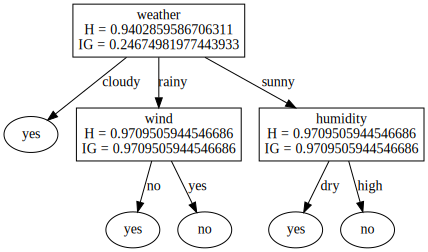

In [23]:
# This is just a visualisation of the graph.
# If it doesn't work, it isn't a big deal (you can move to the next cell).
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display

    graph = Source(id3_classifier.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print("graphviz must be installed")

### 2.2 CART  (Classification and Regression Trees)[[Breiman et al. , 1984](Refrence)]
- Here we will implement the CART algorithm for classification with numerical features.
- For that, we will use the dataset "PlayOut_num.csv" (numerical).

#### 2.2.1 Reading and preparation of data

In [24]:
# Read dataset "PlayOut.csv" using pandas.read_csv
df_playOut_num = pd.read_csv("data/PlayOut_num.csv")
# Print the DataFrame df_playOut
df_playOut_num

,weather,temperature,humidity,wind,playOut
0,sunny,30,85,0,no
1,sunny,27,90,1,no
2,cloudy,28,78,0,yes
3,rainy,21,96,0,yes
4,rainy,20,80,0,yes
5,rainy,18,70,1,no
6,cloudy,18,65,1,yes
7,sunny,22,95,0,no
8,sunny,21,70,0,yes
9,rainy,24,80,0,yes


Next, we need to separate data into : (1) inputs noted X, and (2) outputs(labels, classes) noted Y.

In [25]:
# Get the first columns that represents the features : ['weather','temperature','humidity','wind']
# Not including the last column
X_NumPlayOut = df_playOut_num.iloc[:, :-1].values

# Get the target column : the last column that contains labels (classes)
Y_NumPlayOut = df_playOut_num.iloc[:,-1].values

# Print X
print("X_playOut : \n",X_NumPlayOut)

# Print Y
print("\nY_playOut : \n",Y_NumPlayOut)

X_playOut : 
 [['sunny' 30 85 0]
 ['sunny' 27 90 1]
 ['cloudy' 28 78 0]
 ['rainy' 21 96 0]
 ['rainy' 20 80 0]
 ['rainy' 18 70 1]
 ['cloudy' 18 65 1]
 ['sunny' 22 95 0]
 ['sunny' 21 70 0]
 ['rainy' 24 80 0]
 ['sunny' 24 70 1]
 ['cloudy' 22 90 1]
 ['cloudy' 27 75 0]
 ['rainy' 22 80 1]]

Y_playOut : 
 ['no' 'no' 'yes' 'yes' 'yes' 'no' 'yes' 'no' 'yes' 'yes' 'yes' 'yes' 'yes'
 'no']


#### 2.2.2 Probability Function
Already implemented in ID3 Section

#### 2.2.3 Gini index

- In the classification case, CART uses the Gini index of diversity to measure the classification error.
- An index of 0 represents the best split.

Given :
- $S$ list of values  
- $V$ set of unique values of $S$ (vocabulary)

The diversity index $Gini(S)$ is calculated as follows:

$$Gini(S) = \sum\limits_{v \in V} p(v/S) (1-p(v/S)) = 1 - \sum\limits_{v \in V} p(v/S)^2 $$

In [36]:
# TODO complete the Gini function code
def Gini(S: np.ndarray) -> float:
    V = np.unique(S)
    gini = 1
    ### BEGIN : Write your code here
    for v in V:
        gini -= P(S, v)**2  # Applying the formula: 1 - sum(p(v/S)^2) for each v in V
    ### END
    return gini

In [37]:
#=====================================================================
# UNIT TEST (Run the cell and compare your results)
#=====================================================================
# Result :
# Gini(Y)= 0.4591836734693877
#---------------------------------------------------------------------
print("Gini(Y)=",Gini(Y_NumPlayOut))

Gini(Y)= 0.4591836734693877


#### 2.2.4 Splitting of a set
- *NP : Nothing to code here*

As CART (the decision tree algoritm) generates **binary trees**, we need to code a splitting function that splits the list of predictions (classes) $Y$ according to a given value $v$ of an attribute (feature, column) $A$ into two lists:
- $Y_L$: (left List) a list containing the elements of $Y$ where $a \in A$ : $a > v$
- $Y_R$: (Right List) a list containing the elements of $Y$ where $a \in A$ : $a \le v$

In [38]:
# In the case A is a nominal feature
def split_nom_bin(S, A, value):
    msk     = (A==value)       # Ceate a mask to filter the numpy array S, and return
    S_left  = S[msk]           # the left set : S_{A == values}
    S_right = S[~msk]          # the right set : S_{A != values}
    return S_left, S_right

In [39]:
# In the case A is numerical feature
def split_num_bin(S, A, value):
    msk = A > value            # Ceate a mask to filter the numpy array S
    S_left  = S[msk]           # the left set S_{A > values}
    S_right = S[~msk]          # the right set S_{A <= values}
    return S_left, S_right

In [40]:
def split_CART(S, A, value) :
    '''
    The function checks whether the value is numeric or not.
    It calls the two previous functions depending on the type of the feature
    '''
    try:
        val = float(value)
        return split_num_bin(S, A, val)
    except ValueError:
        return split_nom_bin(S, A, value)

In [41]:
#=====================================================================
# UNIT TEST 01 (Run the cell and compare your results)
#=====================================================================
# Results :
# --------------------------------------------------------------------
# Letf split of Y based on "temperature" (2nd column) feature :
#  ['no' 'no' 'yes' 'yes' 'no' 'yes' 'yes' 'yes' 'yes' 'yes' 'no']
# Righ split of Y based on "temperature" (2nd column) feature :
#  ['yes' 'no' 'yes']
#---------------------------------------------------------------------
# Test with numerical variables
Y_NumPlayOut_letf, Y_NumPlayOut_right = split_CART(Y_NumPlayOut, X_NumPlayOut[:,1], 20)
print("Left split of Y based on \"temperature\" (2nd column) feature : \n", Y_NumPlayOut_letf)
print("Right split of Y based on \"temperature\" (2nd column) feature :\n", Y_NumPlayOut_right)

Letf split of Y based on "temperature" (2nd column) feature : 
 ['no' 'no' 'yes' 'yes' 'no' 'yes' 'yes' 'yes' 'yes' 'yes' 'no']
Righ split of Y based on "temperature" (2nd column) feature :
 ['yes' 'no' 'yes']


In [32]:
#=====================================================================
# UNIT TEST 02 (Run the cell and compare your results)
#=====================================================================
# Results :
# --------------------------------------------------------------------
# Letf split of Y based on "weather" (2nd column) feature :
#  ['no' 'no' 'no' 'yes' 'yes']
# Righ split of Y based on "weather" (2nd column) feature :
#  ['yes' 'yes' 'yes' 'no' 'yes' 'yes' 'yes' 'yes' 'no']
#---------------------------------------------------------------------
# Test with nominal variables
Y_NumPlayOut_letf, Y_NumPlayOut_right = split_CART(Y_NumPlayOut, X_NumPlayOut[:, 0], "sunny")
print("Letf split of Y based on \"weather\" (2nd column) feature : \n", Y_NumPlayOut_letf)
print("Righ split of Y based on \"weather\" (2nd column) feature :\n", Y_NumPlayOut_right)

Letf split of Y based on "weather" (2nd column) feature : 
 ['no' 'no' 'no' 'yes' 'yes']
Righ split of Y based on "weather" (2nd column) feature :
 ['yes' 'yes' 'yes' 'no' 'yes' 'yes' 'yes' 'yes' 'no']


#### 2.2.5 The Gini score of the split


Given :

- $S$: a list (in our case, the list of classes labels)
- $S_L, S_R$ :  **left** and **right** subsets after the split
- $|S| = |S_L| + |S_R|$

The Gini score of the split is calculated as follow :

$$Gini_{split}(S_L, S_R) = \frac{|S_L|}{|S|} Gini(S_L) + \frac{|S_R|}{|S|} Gini(S_R)$$

Our goal is to try to minimize $Gini_{split}$.

In [42]:
# TODO complete the code of the function below to calculate the gini socre of the split

def split_Gini(S_L: np.ndarray, S_R: np.ndarray) -> float:
    SL_len = len(S_L)              # Get the cardinality (length) of the left subset S_L
    SR_len = len(S_R)              # Get the cardinality (length) of the Right subset S_R
    S_len = float(SL_len + SR_len) # Get the cardinality (length) of the set S

    ### BEGIN : Write your code here
    # Hint : follow the formula
    gini_SL_SD = (SL_len / S_len) * Gini(S_L) + (SR_len / S_len) * Gini(S_R) # Applying the formula
    ### END
    return gini_SL_SD

In [43]:
#=====================================================================
# UNIT TEST (Run the cell and compare your results)
#=====================================================================
# Results :
# Gini_split(S_L_numerical, S_R_numerical) = 0.4588744588744589
# Gini_split(S_L_nominal, S_R_nominal) = 0.4666666666666667
#---------------------------------------------------------------------
# There is two way to call the split_Gini function

# 1st way :
# Call split_CART  (in this case we are using a numerical feature to split the predictions)
# Save the new subsets in "S_L_numerical" and "S_R_numerical"
S_L_numerical, S_R_numerical = split_CART(Y_NumPlayOut, X_NumPlayOut[:, 1], 20)
# then call split_Gini
S_gini_num = split_Gini(S_L_numerical, S_R_numerical)
print("Gini_split(S_L_numerical, S_R_numerical) =", S_gini_num)

# 2nd way : Do a nesting function call with the Starred Expression in Python "func(*args)"
# here we calculate the gini score for the split with the nominal feature "Weather"
S_gini_nom = split_Gini(*split_CART(Y_NumPlayOut, X_NumPlayOut[:, 0], "sunny"))
print("Gini_split(S_L_nominal, S_R_nominal) =",S_gini_nom)

Gini_split(S_L_numerical, S_R_numerical) = 0.4588744588744589
Gini_split(S_L_nominal, S_R_nominal) = 0.3936507936507937


#### 2.2.6 Selection of the CART splitting feature
- *PS: Nothing to code here*

**The Pseudo-code :**

- For each feature $X_j$  
   - For each unique value $v$ in $X_j$
       1. Divide $Y$ based on the value of $v$ and those of $X_j$
       2. Calculate the Gini score of this split
       3. Keep the index **selectedFeatureIndex** of the feature that minimizes Gini
       4. Keep Gini minimal **selectedFeature_gini**
       5. Keep the feature split value **selected_val**

In [44]:
# TODO complete by following the pseudo-code
# This function searches for the feature and its value that is the most relevant for spliting  Y

# it must return:
    # selectedFeatureIndex: the index of the selected feature in X
    # selected_val: the split value (the value can be string or numeric)
    # selected_gini: the split gini score

def splitting_feature_CART(X: np.ndarray, Y: np.ndarray) -> Tuple[int, float, float]:
    # Create two empty lists for saving results of diffrent splits
    # So that we could find in later step the one tha minimize the Gini_split function
    Gini_vector_Global = []
    val_vector_Global = []
    # Loop over the features columns in X
    for i in range(X.shape[1]):
        Gini_vector_local = []
        val_vector_local = []
        # Get the column of the selcted feature i
        A = X[:,i]
        # loop over the unique values of the selected feature (do that for each feature in X)
        Vals = np.unique(A)
        for val in Vals:
            # the index of the array represent the index of the feature
            # Save the value "val" of the feature
            val_vector_local.append(val)
            # Split over the entire selected feature with given value "val", and save the Gini_score score
            Gini_vector_local.append(split_Gini(*split_CART(Y,A,val)))

        # Minimize Gini Score for this feature
        # Get and save the min Gini value
        Min = np.amin(Gini_vector_local)
        Gini_vector_Global.append(Min)
        # Get and save the value that minimize Gini value for this feature
        v   = val_vector_local[np.argmin(Gini_vector_local)]
        val_vector_Global.append(v)

    # minimiser gini score across all the features
    selectedFeatureIndex = np.argmin(np.array(Gini_vector_Global))
    selectedFeature_gini= min(Gini_vector_Global)
    selected_val = val_vector_Global[selectedFeatureIndex]

    return selectedFeatureIndex, selectedFeature_gini, selected_val

In [45]:
#=====================================================================
# UNIT TEST (Run the cell and compare your results)
#=====================================================================
# Results :
# selected Feature Index :  0
# Gini Spliting Score :  0.35714285714285715
# Spliting Value :  cloudy
#---------------------------------------------------------------------
selectedFeatureIndex, gini_score, selectedFeature_val = splitting_feature_CART(X_NumPlayOut, Y_NumPlayOut)
print("selected Feature Index : ", selectedFeatureIndex)
print("Gini Spliting Score : ", gini_score)
print("Spliting Value : ", selectedFeature_val)

selected Feature Index :  0
Gini Spliting Score :  0.35714285714285715
Spliting Value :  cloudy


#### 2.2.7 Creation of the decision tree CART
*PS : Nothing to code here*
- CART uses the pre-splitting method referred to by the stopping condition.
- The most used criterion to stop the splitting is the minimal number of samples in a node. If we reach this number, we do not divide anymore and we consider the node as a leaf with the dominant class as output class in case of ranking, or the average of the outputs in case of regression.

In [46]:
class BinNode(object):
    '''
    BinNode Class : A class to hold the Binary Node information and the list of its children (two children).
    '''
    nb = 0

    def __init__(self, featureId, val, gini, depth):
        self.featureId = featureId # The index in X of the feature we used for spliting to get this node
        self.val = val             # The split value
        self.gini = gini           # Gini Score of the split
        self.depth = depth         # the depth of the node
        self.children = []         # Node children, as we have two children (S_L, S_R) we store them in a list of type Node
        self.cls = ""              # the class if this the node is final (if there are no children)
        self.indent = "    "       # indentation when generating the pseaudo code
        # save the type of the feature
        try: # case it is numerical
            val2 = float(val)
            self.is_num = True
        except ValueError: # case it's a nominal (string)
            self.is_num = False

    def __str__(self):
        '''
        This function (parser) is to transform the node to a string.
        Here we have redefined this function to write the tree as a pseaudo algorithm.
        '''
        # indentation: aesthetics
        indent = self.indent * self.depth

        if (len(self.children)==0):
            return indent + 'Y IS "' + self.cls + '"\n'
        if (self.is_num):
            prefix = ' > '
            suffix = ''
        else:
            prefix = ' IS "'
            suffix = '"'

        res = ""
        res += indent + 'IF X[' + str(self.featureId) + '] ' + prefix + str(self.val) + suffix + ' THEN \n' + str(self.children[0])
        res += indent + 'ELSE \n' + str(self.children[1])
        return res

    def predict(self, x):
        '''
        Prediction Function : Given and instnace X it return the predicted target class Y'
        '''
        # IF the node is final, it returns its class
        if (len(self.children)==0):
            return self.cls
        # ELSE
        # in case it's numerical feature
        if self.is_num:
            if x[self.featureId] > self.val:
                return self.children[0].predict(x)
            return self.children[1].predict(x)
        # in case it's nominal feature (string)
        if x[self.featureId] == self.val:
            return self.children[0].predict(x)
        return self.children[1].predict(x)


    def graphviz(self):
        '''
        This function generate the Pseudocode for graphviz
        '''
        nid = 'N' + str(BinNode.nb)
        BinNode.nb += 1
        # If the node is a final one,
        if (len(self.children)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        # Else if there are children nodes, we loop over them and print IF ... THEN .. structure
        if self.is_num:
            prefix = '] > '
        else:
            prefix = '] = '
        res = nid + '[label="X[' + str(self.featureId) + prefix + str(self.val) + '\\n'
        res += 'Gini = ' + str(self.gini) + '"];\n'
        vid_L, code_L = self.children[0].graphviz()
        vid_R, code_R = self.children[1].graphviz()

        res += code_L + code_R
        res += nid + ' -> ' + vid_L + ' [label="Vrai"];\n'
        res += nid + ' -> ' + vid_R + ' [label="Faux"];\n'
        return nid, res

In [47]:
def train_CART(X, Y, depth=0, nb_max=3):
    '''
    Training function : Learn and create the decision tree from a set of X (features) and Y(Target/Labels)
    '''
    f_index, f_gini, f_val = splitting_feature_CART(X, Y) # Find the best relevant feature of X to split Y
    node = BinNode(f_index, f_val, f_gini, depth)         # Create a node

    if (f_gini == 0.0) or (len(Y) <= nb_max):             # Pruning
        node.cls = max(set(Y))                            # the class of the node (most frequent value)
        return node                                       # return the node

    # Otherwise, if the node is not terminal, we create its children nodes
    depth += 1

    # creation of the two children nodes
    try:
        val2 = float(f_val)
        msk = X[:, f_index] > val2
    except ValueError:
        msk = (X[:, f_index]==f_val)

    X_L = X[msk]
    Y_L = Y[msk]
    children_L = train_CART(X_L, Y_L, depth, nb_max)

    X_R = X[~msk]
    Y_R = Y[~msk]
    children_R = train_CART(X_R, Y_R, depth, nb_max)
    node.children.append(children_L)
    node.children.append(children_R)

    return node

In [48]:
playOut_Tree_CART = train_CART(X_NumPlayOut, Y_NumPlayOut)

print("The Decision Tree CART Pseudocode : \n")
print(playOut_Tree_CART)

# Test our model on a sample (new instance) : ["cloudy", "no_temperature", "no_humidity", "no"]
x_test = ["cloudy", "no_temperature", "no_humidity", "no"]
pred = playOut_Tree_CART.predict(x_test)
print("X = ",x_test," | Prediction : Y'=",pred)

The Decision Tree CART Pseudocode : 

IF X[0]  IS "cloudy" THEN 
    Y IS "yes"
ELSE 
    IF X[1]  > 24 THEN 
        Y IS "no"
    ELSE 
        IF X[1]  > 18 THEN 
            IF X[1]  > 21 THEN 
                Y IS "yes"
            ELSE 
                Y IS "yes"
        ELSE 
            Y IS "no"

X =  ['cloudy', 'no_temperature', 'no_humidity', 'no']  | Prediction : Y'= yes


#### 2.2.8 Bundling all functions together
Nothing to program here. There is a question to answer.


In [49]:
class CART(object):

    def train(self, X, Y, X_names=[], Y_name="", nb_max=3):
        self.tree = train_CART(X, Y, 0, nb_max)
        pseudoCode = str(self.tree)
        if len(Y_name) > 0:
            pseudoCode = pseudoCode.replace("Y", Y_name)
        for i in range(len(X_names)):
            pseudoCode = pseudoCode.replace("X[" + str(i) + "]", X_names[i])
        self.pseudoCode = pseudoCode
        self.X_names = X_names

    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            predictions.append(self.tree.predict(X[i, :]))
        return predictions

    def graphviz(self):
        nid, pseudoCode = self.tree.graphviz()
        res = "digraph Tree {\n"
        res += "node [shape=box] ;"
        for i in range(len(self.X_names)):
            pseudoCode = pseudoCode.replace("X[" + str(i) + "]", self.X_names[i])
        res += pseudoCode
        res += "}"
        return res

In [50]:
cart_classifier = CART()
cart_classifier.train(X_NumPlayOut, Y_NumPlayOut, X_names=["weather", "temperature", "humidity", "wind"], Y_name="PlayOut")
print(cart_classifier.pseudoCode)

IF weather  IS "cloudy" THEN 
    PlayOut IS "yes"
ELSE 
    IF temperature  > 24 THEN 
        PlayOut IS "no"
    ELSE 
        IF temperature  > 18 THEN 
            IF temperature  > 21 THEN 
                PlayOut IS "yes"
            ELSE 
                PlayOut IS "yes"
        ELSE 
            PlayOut IS "no"



**Question (Q4):**

In the pseudo-code, we notice that the decision tree does not take into account the "humidity" and "wind" features.

**Unique_Value(weather)** = {'sunny', 'cloudy', 'rainy'}

**Unique_Value(temperature)** = {18, 20, 21, 22, 24, 27, 28, 30}

**Unique_Value(humidity)** = {65, 70, 75, 78, 80, 85, 90, 95, 96}

**Unique_Value(wind)** = {'no', 'yes'}

- What can you say about this?

**Your Answer (A4) :**
[ Write your answer here ]

- The CART algorithm seemed to favor the features with better predictive power and less risk of overfitting, leading to the simpler tree structure.

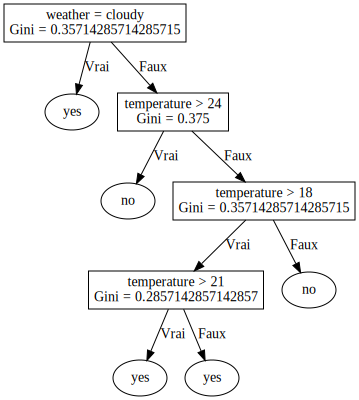

In [51]:
# C'est juste une visualisation du graphe
# Si ça ne marche pas, ce n'ai pas grave
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display

    graph = Source(cart_classifier.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print("il faut installer graphviz")

### 2.3 Benchmarking and analysis
Here you are not going to code, but understand and analyse the results.

#### 2.3.1 Decision Tree Generation
Here, we will do a comparaison of ID3 vs CART based on how they generate the decision tree.

**Reminder :**
- ID3 :
    - uses the entropy
    - the number of node's children is according to the number of values
- CART :
    - uses the Gini index
    - the number of node's leafs is binary
    
Here, we will use the "**PlayOut.csv**" dataset with nominal values

In [52]:
id3_nom_classifier = ID3()
id3_nom_classifier.train(X_playOut, Y_playOut, X_names=["weither", "temperature", "humidity", "wind"], Y_name="PlayOut")
print("ID3 Pseudo-code :\n")
print(id3_nom_classifier.pseudoCode)
print("\n--------------\n")
cart_nom_classifier = CART()
cart_nom_classifier.train(X_playOut, Y_playOut, X_names=["weither", "temperature", "humidity", "wind"], Y_name="PlayOut")
print("CART Pseudo-code :\n")
print(cart_nom_classifier.pseudoCode)

ID3 Pseudo-code :

IF weither IS "cloudy" THEN
    PlayOut IS "yes"
IF weither IS "rainy" THEN
    IF wind IS "no" THEN
        PlayOut IS "yes"
    IF wind IS "yes" THEN
        PlayOut IS "no"
IF weither IS "sunny" THEN
    IF humidity IS "dry" THEN
        PlayOut IS "yes"
    IF humidity IS "high" THEN
        PlayOut IS "no"


--------------

CART Pseudo-code :

IF weither  IS "cloudy" THEN 
    PlayOut IS "yes"
ELSE 
    IF humidity  IS "dry" THEN 
        IF wind  IS "no" THEN 
            PlayOut IS "yes"
        ELSE 
            PlayOut IS "yes"
    ELSE 
        IF weither  IS "rainy" THEN 
            PlayOut IS "yes"
        ELSE 
            PlayOut IS "no"



**Analyze these results (Q5)**
- Comparison between ID3 and CART according to their way of generating the tree.
- Analyze the depth, the features used, the type of tree and maybe the impact on the prediction speed (worst case).

**Your Answer (A5):**
[ Write your answer here ]

ID3 :
- ID3 builds a multi-way tree (max depth 3) using "weather," "wind," and "humidity" based on Information Gain.

CART :
- CART builds a binary tree (max depth 4) using "weather," "humidity," and "wind" based on Gini Impurity.

Visualization of ID3 Decision Tree :


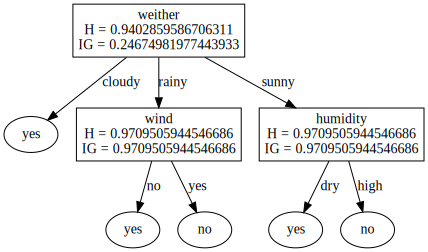


-------------------------------------------------------------------------------

Visualization of CART Decision Tree :


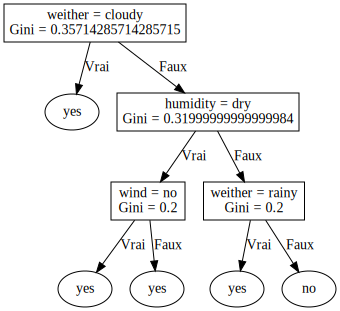

In [53]:
# This is just a visualisation of the graph.
# If it doesn't work, it isn't a big deal (you can move to the next cell).
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display

    print("Visualization of ID3 Decision Tree :")
    graph1 = Source(id3_nom_classifier.graphviz())
    display(SVG(graph1.pipe(format='svg')))

    print("\n-------------------------------------------------------------------------------\n")

    print("Visualization of CART Decision Tree :")
    graph2 = Source(cart_nom_classifier.graphviz())
    display(SVG(graph2.pipe(format='svg')))

except ImportError:
    print("graphviz must be installed")

#### 2.3.2 Benchmarking based on Types of attributs  

Here, we will compare between two CART classifiers applied on :

- Nominal data (categorical); already trained
- Mixed data (numerical and nominal)

In [54]:
# Reminder : Be careful
'''
X_playOut, Y_playOut : contains only nominal data
X_NumPlayOut, Y_NumPlayOut : contains numerical and nominal data
'''

print("CART with nominal features: :")
print("============================================")
print(cart_nom_classifier.pseudoCode)

print("")

cart_num_classifier = CART()
cart_num_classifier.train(X_NumPlayOut, Y_NumPlayOut, X_names=["weither", "temperature", "humidity", "wind"], Y_name="PlayOut")

print("CART with some numerical features :")
print("================================================")
print(cart_num_classifier.pseudoCode)

CART with nominal features: :
IF weither  IS "cloudy" THEN 
    PlayOut IS "yes"
ELSE 
    IF humidity  IS "dry" THEN 
        IF wind  IS "no" THEN 
            PlayOut IS "yes"
        ELSE 
            PlayOut IS "yes"
    ELSE 
        IF weither  IS "rainy" THEN 
            PlayOut IS "yes"
        ELSE 
            PlayOut IS "no"


CART with some numerical features :
IF weither  IS "cloudy" THEN 
    PlayOut IS "yes"
ELSE 
    IF temperature  > 24 THEN 
        PlayOut IS "no"
    ELSE 
        IF temperature  > 18 THEN 
            IF temperature  > 21 THEN 
                PlayOut IS "yes"
            ELSE 
                PlayOut IS "yes"
        ELSE 
            PlayOut IS "no"



**Analyze these results (Q6)** :
- Analyzes the impact of characteristic types.
 * Categorical data  
 * Heterogeneous data (categorical and numerical)
- The analysis could be based on the generated pseudo-code (or tree) according to the previous criteria.

**Your Answer (A6) :**
[ Write your answer here ]

- While both CART trees reached a depth of 4, the tree with solely categorical data created more complex branches using "weather," "humidity," and "wind." In contrast, the tree with heterogeneous data prioritized simpler, threshold-based splits on "weather" and numerical "temperature,".

Visualization of CART Decision Tree on only nominal features :


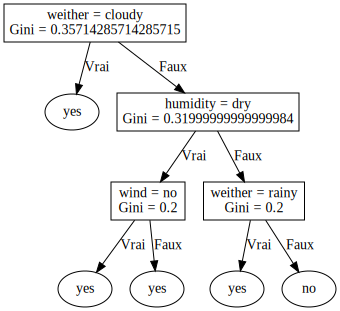


-------------------------------------------------------------------------------

Visualization of CART Decision Tree on heterogeneous data (features):


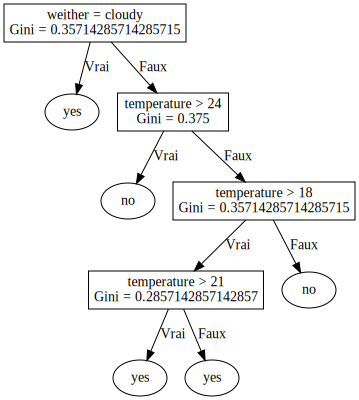

In [55]:
# This is just a visualisation of the graph.
# If it doesn't work, it isn't a big deal (you can move to the next cell).

try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display

    print("Visualization of CART Decision Tree on only nominal features :")
    graph1 = Source(cart_nom_classifier.graphviz())
    display(SVG(graph1.pipe(format='svg')))

    print("\n-------------------------------------------------------------------------------\n")

    print("Visualization of CART Decision Tree on heterogeneous data (features):")
    graph2 = Source(cart_num_classifier.graphviz())
    display(SVG(graph2.pipe(format='svg')))

except ImportError:
    print("graphviz must be installed")

####  2.2.3 Benchmarking Performance : Sklearn VS Our models

- In this section, We compare our implementation of ID3 and CART model against a the high-level implementation of decision tree classifiers with the python "Scikit-Learn" library.

- We will use [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) to classify flowers in three classes, using 4 features.

We will train three models :
- ID3 after discritization of the values
- CART
- Decision tree with scikit-learn library

Description of the metrics :
- the support is the number of samples
- for each class, we provide the precision, the recall and the F1-score
- micro avg : the metrics (precision, recall and F1-score) computed for the totality of the estimations (useful when the number of classes is unbalanced)
- macro avg : the metrics computed for each class, then averaged
- weighted avg: the metrics calculated for each class, multiplied by the equivalent support, summed, then divided by the total number of samples

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

iris = pd.read_csv("data/iris.csv")
iris = iris.sample(frac=1)
# Extraction des features
X_iris = iris.iloc[:, :-1].values # Premières colonnes

Y_iris = iris.iloc[:,-1].values # Dernière colonne

X_names = list(iris.columns)[:-1]
Y_name = list(iris.columns)[-1]

# Split data on two sets : Training Set (80%) - Test Set (20%)

## create a mask for filtering dataset, by creating 80% of randomly true labls
## e.g, for a dataset with 5 instances (examples, rows),
## we could generate a boolean mask array like : [True, True, True, False, True]
## where 80% of boolean values are "True"
iris_msk = np.random.rand(len(X_iris)) < 0.8

## Train set :  Rows with "True" labels in the mask array
X_iris_train = X_iris[iris_msk]
Y_iris_train = Y_iris[iris_msk]

## Test set :  Rows with "False" labels in the mask array
## to select these rows in pandas, we need to invert the values of the boolean mask array
## for the previous example we will get the following mask array : [False, False, False, True, False]
## ~ : it's a logical not operation

X_iris_test = X_iris[~iris_msk]
Y_iris_test = Y_iris[~iris_msk]

# print first 20 rows
iris.head(20)
#X_names, Y_name

,sepal_length,sepal_width,petal_length,petal_width,class
143,6.8,3.2,5.9,2.3,Iris-virginica
14,5.8,4.0,1.2,0.2,Iris-setosa
93,5.0,2.3,3.3,1.0,Iris-versicolor
124,6.7,3.3,5.7,2.1,Iris-virginica
84,5.4,3.0,4.5,1.5,Iris-versicolor
40,5.0,3.5,1.3,0.3,Iris-setosa
104,6.5,3.0,5.8,2.2,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica
3,4.6,3.1,1.5,0.2,Iris-setosa
121,5.6,2.8,4.9,2.0,Iris-virginica


In [57]:
# Traget classes : we have 3 classes
print(np.unique(Y_iris))

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


##### Building Our Models :

##### 1\ ID3 after discritization

- STEP 01 : Deatures Discritization

In [60]:
# import frome sklearn library the KBinsDiscretizer function :
# to transforme continuous data into intervals (discritization) .
# Check the documentation : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html
from sklearn.preprocessing import KBinsDiscretizer

est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
# Fit the data
est.fit(X_iris)
# Transform the date
X_iris_disc = est.transform(X_iris)

In [61]:
# print the first 10 rows
X_iris_disc[:10]

array([[2., 1., 2., 2.],
       [1., 2., 0., 0.],
       [0., 0., 1., 1.],
       [2., 1., 2., 2.],
       [0., 1., 1., 1.],
       [0., 1., 0., 0.],
       [1., 1., 2., 2.],
       [1., 1., 2., 2.],
       [0., 1., 0., 0.],
       [1., 0., 1., 2.]])

- STEP 02 : Train the model

In [62]:
# Get "Training" data out the uniformally discretized data
X_iris_disc_train = X_iris_disc[iris_msk]

# Train the model Like Cristiano Ronaldo
id3_iris = ID3()
id3_iris.train(X_iris_disc_train, Y_iris_train, X_names=X_names, Y_name=Y_name, pruning=True)

# Evaluation : predict the the unseen test attributs
# Get "Testing" data out the uniformally discretized data
X_iris_disc_test = X_iris_disc[~iris_msk]
id3_iris_res = id3_iris.predict(X_iris_disc_test)

##### 2\ CART Model

In [63]:
# Train CART classifier
cart_iris = CART()
cart_iris.train(X_iris_train, Y_iris_train, X_names=X_names, Y_name=Y_name)
cart_iris_res = cart_iris.predict(X_iris_test)

##### 3\ Build and Train a Decision Tree (classifier) with scikit-learn library
- **Scikit-learn (Sklearn)** is a python library for machine learning. It provides a selection of tools for machine learning and statistical modeling : including classification, regression and clustering ... via a Python interface. This library, which is largely written in Python, is built upon NumPy, SciPy and Matplotlib.
- To builf decision trees with this high level library we call the **DecisionTreeClassifier** class.
- **DecisionTreeClassifier :** is a class capable of performing multi-class classification on a dataset.
- Check Also : https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier


**NB:** *In the Scikit-learn implementation of decision trees, the features are randomly swapped at each division. This makes the tree non-deterministic. To stop this, we use the property random_state=0.*

In [64]:
# sklearn
from sklearn.tree import DecisionTreeClassifier

sklearn_cart_iris = DecisionTreeClassifier(random_state=0)
sklearn_cart_iris.fit(X_iris_train, Y_iris_train)
sklearn_cart_iris_res = sklearn_cart_iris.predict(X_iris_test)

**Benchmarking :**

In [65]:
# The classification evaluation report
from sklearn.metrics import classification_report

print("ID3")
print(classification_report(Y_iris_test, id3_iris_res))


print("CART")
print(classification_report(Y_iris_test, cart_iris_res))

print("Scikit-learn")
print(classification_report(Y_iris_test, sklearn_cart_iris_res))

# Ignore the warning

ID3
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        16
Iris-versicolor       1.00      0.88      0.93         8
 Iris-virginica       0.89      1.00      0.94         8

       accuracy                           0.97        32
      macro avg       0.96      0.96      0.96        32
   weighted avg       0.97      0.97      0.97        32

CART
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        16
Iris-versicolor       0.00      0.00      0.00         8
 Iris-virginica       0.50      1.00      0.67         8

       accuracy                           0.75        32
      macro avg       0.50      0.67      0.56        32
   weighted avg       0.62      0.75      0.67        32

Scikit-learn
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        16
Iris-versicolor       1.00      0.88      0.93         8
 I

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Analyze these results (Q7):**

- Test the performance of three models
- The comparison must be based on the metrics : precision, recall and F1 score.

**Your Answer (A7):**
[ Write your answer here ]

ID3:
- High accuracy (0.97), consistent F1-scores (1.00, 0.93, 0.94) across all Iris classes.
- Robust and accurate classification, comparable to Scikit-learn.

CART:
- Lower accuracy (0.75), failed on 'Iris-versicolor' (F1-score 0.00).
- Limited performance, potentially due to overfitting or splitting issues.


## References
1. [Quinlan, J. R. (1986). Induction of decision trees. Machine learning, 1(1), 81-106.](https://link.springer.com/content/pdf/10.1007/BF00116251.pdf)

2. [Quinlan, J. R. C4.5: Programs for Machine Learning. Morgan Kaufmann Publishers, 1993.](https://books.google.fr/books?hl=fr&lr=&id=b3ujBQAAQBAJ&oi=fnd&pg=PP1&dq=C4.+5:+Programs+for+machine+learning&ots=sR7pRTJuC2&sig=hmtbed3-eUljdUvf6eoM2vfrbHQ&redir_esc=y#v=onepage&q=C4.%205%3A%20Programs%20for%20machine%20learning&f=false)

4. [Breiman, L., Freidman, J.H., Olshen, R.A., & Stone, C.J. (1984). CART: Classification and Regression Trees.](http://www.math.ku.dk/~richard/courses/statlearn2009/lecture10.pdf).
5. [Shannon, C. E. (1948). A mathematical theory of communication. The Bell system technical journal, 27(3), 379-423.](https://pure.mpg.de/rest/items/item_2383164/component/file_2383163/content)